In [1]:
import pandas as pd

In [2]:
# Load the dataset
df = pd.read_csv('customer_churn_data jyoti.csv')

# Show first few rows
print(df.head())

# Get info about columns & datatypes
print(df.info())

# Check for missing values
print(df.isnull().sum())


  CustomerID  Age  Gender Location     Occupation Income Bracket  \
0  CUST00000   49   Other     West        Retired            Low   
1  CUST00001   53    Male     West       Salaried            Low   
2  CUST00002   67  Female    North  Self-employed         Medium   
3  CUST00003   54    Male    South  Self-employed         Medium   
4  CUST00004   65    Male    South        Student         Medium   

   Credit Score Onboarding Date Channel  App Logins  ...  Current Plan  \
0           792      2019-07-28  Branch        21.0  ...        Silver   
1           356      2011-03-28  Online         4.0  ...      Platinum   
2           441      2017-11-21  Branch         NaN  ...         Basic   
3           708      2017-03-18  Online        11.0  ...          Gold   
4           377      2011-04-22  Online        10.0  ...          Gold   

      Plan History  Subscription Renewals Payment Mode Tickets Raised  \
0    Silver > Gold                      0         Auto            4.0   


In [3]:
df.fillna({
    'Occupation': df['Occupation'].mode()[0],
    'App Logins': df['App Logins'].median(),
    'Monthly Avg Balance': df['Monthly Avg Balance'].median(),
    'Tickets Raised': df['Tickets Raised'].median()
}, inplace=True)

In [4]:
df['Onboarding Date'] = pd.to_datetime(df['Onboarding Date'])

In [5]:
print(df['Churned'].value_counts(normalize=True))

Churned
0    0.8038
1    0.1962
Name: proportion, dtype: float64


In [6]:
!pip install imbalanced-learn

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create a copy
df_encoded = df.copy()

# Encode all object (categorical) columns
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'CustomerID':  # skip CustomerID
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le


In [8]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. Copy the DataFrame
df_encoded = df.copy()

# 2. Drop the 'CustomerID' and 'Onboarding Date' (SMOTE can't handle datetime)
df_encoded.drop(columns=['CustomerID', 'Onboarding Date'], inplace=True)

# 3. Encode categorical columns
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# 4. Define X and y
X = df_encoded.drop(columns=['Churned'])
y = df_encoded['Churned']

# 5. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 6. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 7. Check the result
print(y_train_bal.value_counts())


Churned
0    6430
1    6430
Name: count, dtype: int64


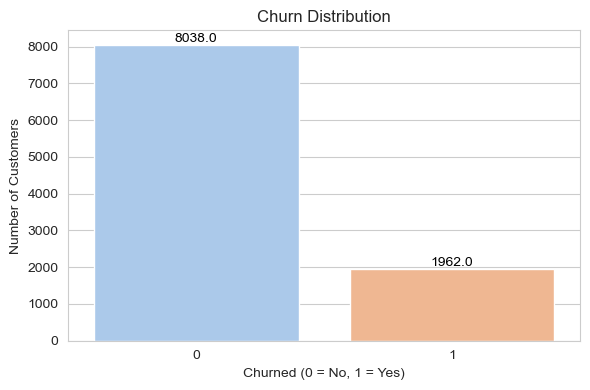

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Use hue as recommended
ax = sns.countplot(x='Churned', hue='Churned', data=df, palette='pastel', legend=False)

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=10, color='black')

# Titles and labels
plt.title('Churn Distribution')
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


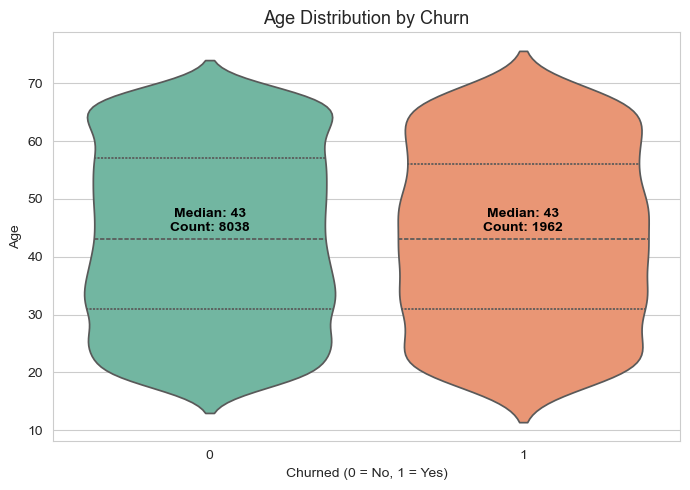

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Style
sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))

# Palette
palette = 'Set2'

# Violin plot with quartiles
ax = sns.violinplot(x='Churned', y='Age', hue='Churned', data=df,
                    palette=palette, inner="quartile", legend=False)

# Median labels
medians = df.groupby('Churned')['Age'].median()
counts = df['Churned'].value_counts().sort_index()  # 0, 1 order

for i, (median, count) in enumerate(zip(medians, counts)):
    ax.text(i, median + 1, 
            f'Median: {int(median)}\nCount: {count}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Titles and axis labels
plt.title('Age Distribution by Churn', fontsize=13)
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.tight_layout()
plt.show()


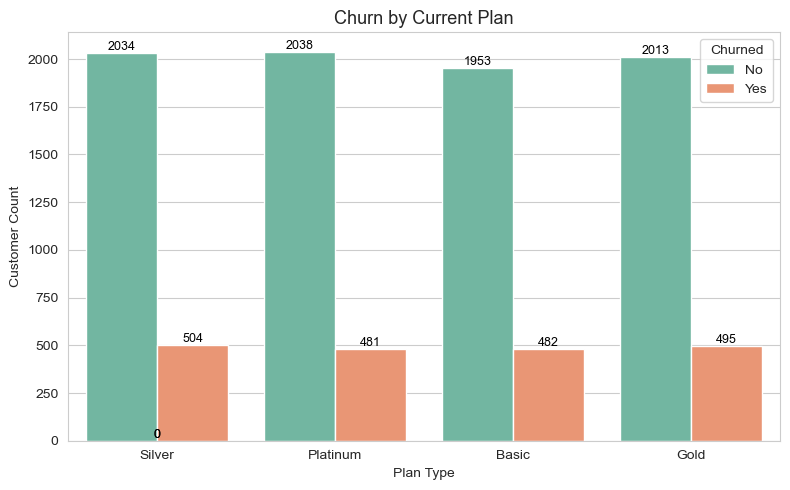

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Professional soft color palette (Set2 works well here)
ax = sns.countplot(x='Current Plan', hue='Churned', data=df, palette='Set2')

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

# Customize axes and legend
plt.title('Churn by Current Plan', fontsize=13)
plt.xlabel('Plan Type')
plt.ylabel('Customer Count')
plt.legend(title='Churned', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

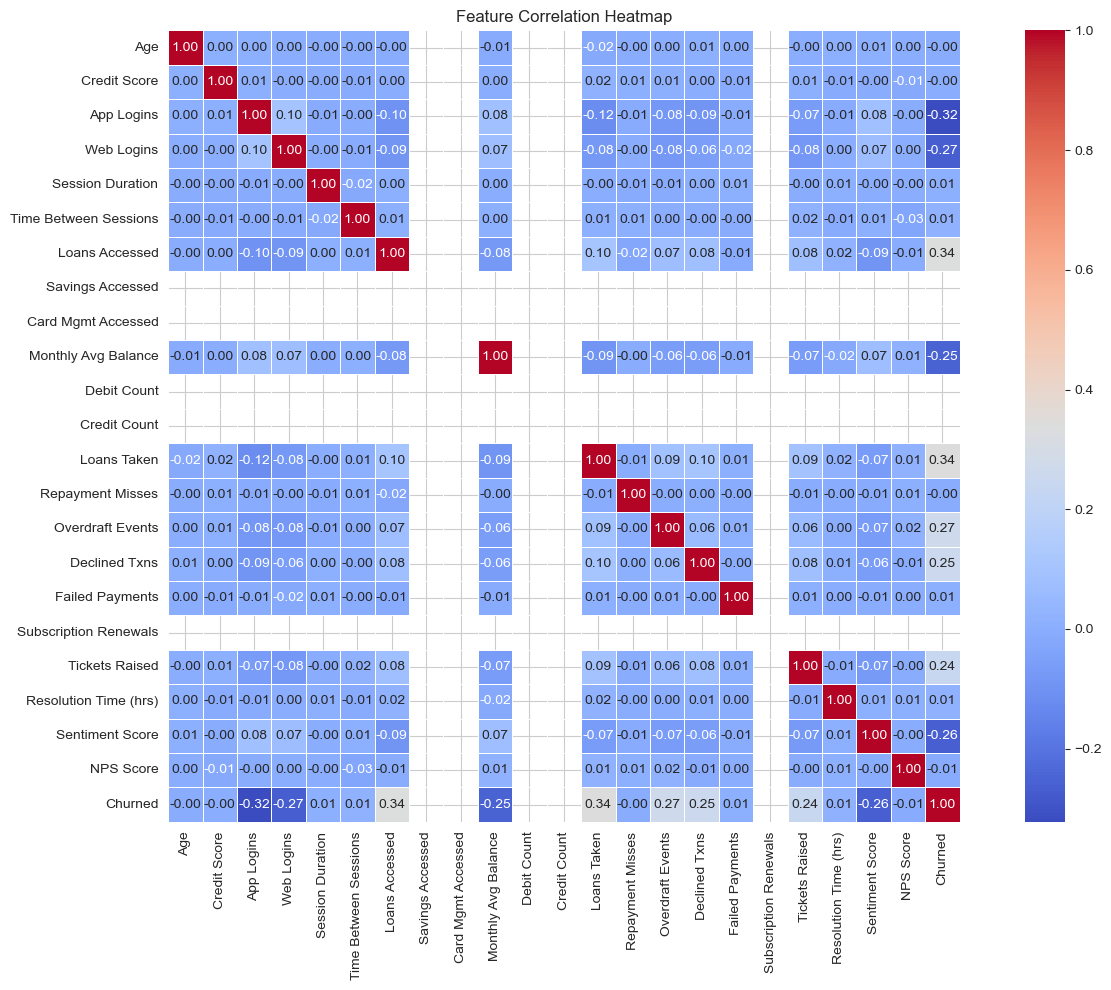

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Correlation matrix
corr = numeric_df.corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

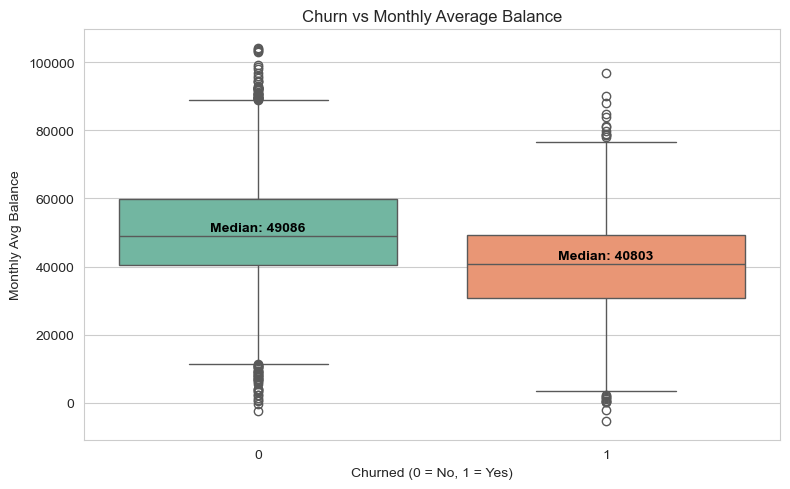

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Set proper hue and remove legend
ax = sns.boxplot(x='Churned', y='Monthly Avg Balance', hue='Churned',
                 data=df, palette='Set2', legend=False)

# Optional: Add median labels
medians = df.groupby('Churned')['Monthly Avg Balance'].median()
for i, median in enumerate(medians):
    ax.text(i, median + 500, f'Median: {int(median)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title('Churn vs Monthly Average Balance')
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Monthly Avg Balance')
plt.tight_layout()
plt.show()

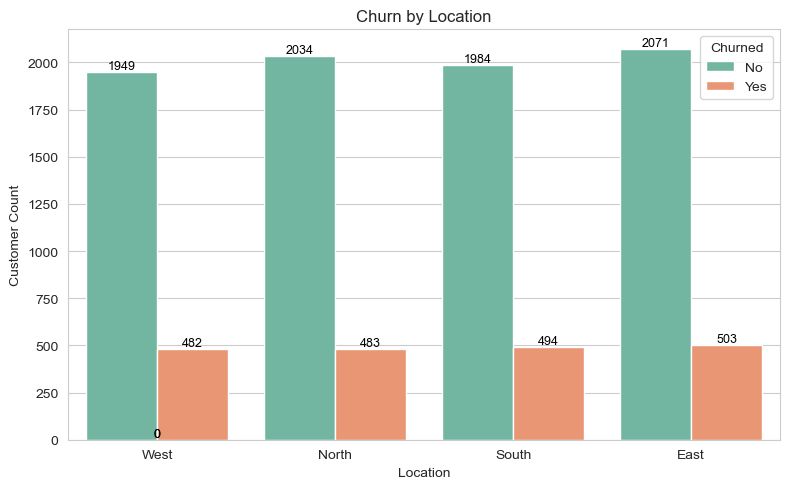

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Plot
ax = sns.countplot(x='Location', hue='Churned', data=df, palette='Set2')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

# Titles and labels
plt.title('Churn by Location')
plt.xlabel('Location')
plt.ylabel('Customer Count')
plt.legend(title='Churned', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

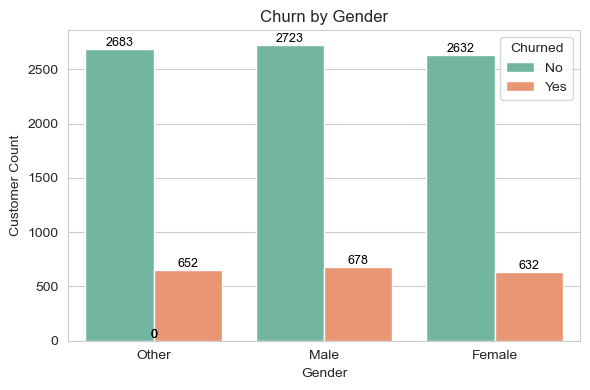

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure style and size
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Countplot
ax = sns.countplot(x='Gender', hue='Churned', data=df, palette='Set2')

# Add data labels to each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

# Titles and layout
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Customer Count')
plt.legend(title='Churned', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

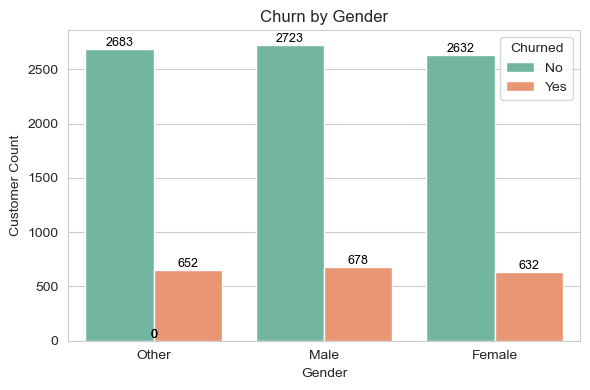

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Create the plot and assign it to 'ax' so we can label it
ax = sns.countplot(x='Gender', hue='Churned', data=df, palette='Set2')

# ✅ Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

# Axis titles and legend
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Customer Count')
plt.legend(title='Churned', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


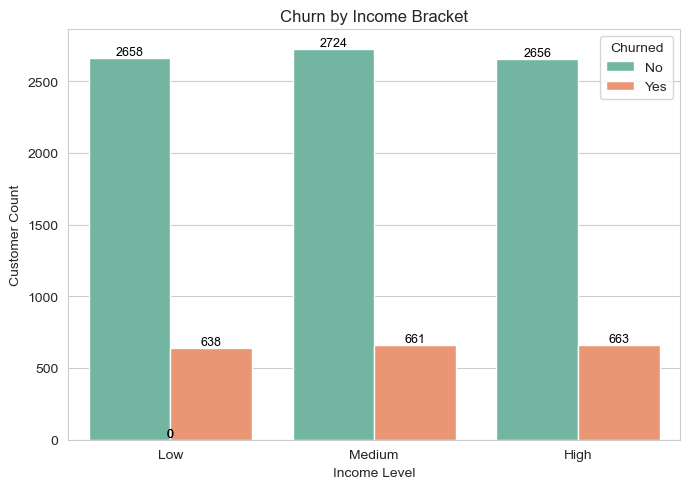

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))

ax = sns.countplot(x='Income Bracket', hue='Churned', data=df, palette='Set2')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

# Labels and layout
plt.title('Churn by Income Bracket')
plt.xlabel('Income Level')
plt.ylabel('Customer Count')
plt.legend(title='Churned', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import LabelEncoder

df_fe = df.copy()  # FE = Feature Engineered version

label_cols = df_fe.select_dtypes(include='object').columns.tolist()
label_cols = [col for col in label_cols if col not in ['CustomerID', 'Onboarding Date']]

label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df_fe[col] = le.fit_transform(df_fe[col])
    label_encoders[col] = le

In [18]:
df_fe['Onboarding Date'] = pd.to_datetime(df_fe['Onboarding Date'])

In [19]:
df_fe['Tenure_Years'] = (pd.Timestamp('today') - df_fe['Onboarding Date']).dt.days // 365

In [20]:
df_fe.drop(columns=['Onboarding Date'], inplace=True)

In [21]:
#IQR Method Example
Q1 = df_fe['Monthly Avg Balance'].quantile(0.25)
Q3 = df_fe['Monthly Avg Balance'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create outlier flag
df_fe['Balance_Outlier'] = df_fe['Monthly Avg Balance'].apply(
    lambda x: 1 if x < lower_bound or x > upper_bound else 0
)

In [22]:
df_fe['Engagement_Score'] = (
    df_fe['App Logins'] + df_fe['Web Logins']
) / (df_fe['Time Between Sessions'] + 1)

In [23]:
df_fe.head()

,CustomerID,Age,Gender,Location,Occupation,Income Bracket,Credit Score,Channel,App Logins,Web Logins,...,Payment Mode,Tickets Raised,Resolution Time (hrs),Sentiment Score,NPS Score,Survey Feedback,Churned,Tenure_Years,Balance_Outlier,Engagement_Score
0,CUST00000,49,2,3,0,1,792,1,21.0,11.0,...,0,4.0,26.993946,0.570978,2,0,0,5,0,3.747822
1,CUST00001,53,1,3,1,1,356,2,4.0,3.0,...,0,0.0,101.537031,0.832714,7,1,1,14,0,0.193506
2,CUST00002,67,0,1,2,2,441,1,11.0,9.0,...,1,2.0,29.379271,0.442001,6,0,0,7,0,0.383041
3,CUST00003,54,1,2,2,2,708,2,11.0,6.0,...,0,1.0,167.618638,0.264915,5,2,0,8,0,2.278132
4,CUST00004,65,1,2,3,2,377,2,10.0,12.0,...,0,0.0,5.694075,0.253205,5,1,0,14,0,0.653026


In [24]:
columns_to_drop = ['CustomerID', 'Plan History', 'Payment Mode', 'Survey Feedback']
df_fe.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [25]:

import numpy as np

# Correlation matrix
corr = df_fe.corr().abs()

# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Drop features with >0.9 correlation
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Highly correlated columns to consider dropping:", to_drop_corr)

Highly correlated columns to consider dropping: []


In [26]:
df_fe.drop(columns=to_drop_corr, inplace=True)

In [27]:
import pandas as pd
import numpy as np

# Correlation matrix
corr_matrix = df_fe.corr().abs()

# Upper triangle only (no repetition)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Filter for correlations > 0.9
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.9]

# Show sorted result
high_corr_pairs.sort_values(by='Correlation', ascending=False)


,Feature1,Feature2,Correlation


In [28]:

print(df_fe.shape)
print(df_fe.columns)


(10000, 34)
Index(['Age', 'Gender', 'Location', 'Occupation', 'Income Bracket',
       'Credit Score', 'Channel', 'App Logins', 'Web Logins',
       'Session Duration', 'Time Between Sessions', 'Device Type',
       'OS Version', 'Loans Accessed', 'Savings Accessed',
       'Card Mgmt Accessed', 'Monthly Avg Balance', 'Debit Count',
       'Credit Count', 'Loans Taken', 'Repayment Misses', 'Overdraft Events',
       'Declined Txns', 'Failed Payments', 'Current Plan',
       'Subscription Renewals', 'Tickets Raised', 'Resolution Time (hrs)',
       'Sentiment Score', 'NPS Score', 'Churned', 'Tenure_Years',
       'Balance_Outlier', 'Engagement_Score'],
      dtype='object')


In [29]:
#✅ Phase 4A Roadmap Execution
#🔹 Step 1: Train-Test Split (Stratified)
from sklearn.model_selection import train_test_split

X = df_fe.drop(columns=['Churned'])   # Features
y = df_fe['Churned']                  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [30]:
#Train Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split data
X = df_fe.drop(columns=['Churned'])
y = df_fe['Churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create pipeline: scaling + logistic regression
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Fit model
log_reg_pipeline.fit(X_train, y_train)

# Predict
y_pred_log = log_reg_pipeline.predict(X_test)

# Evaluate
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 Model Performance: {name}")
    print("Accuracy:      ", round(accuracy_score(y_true, y_pred), 3))
    print("Precision:     ", round(precision_score(y_true, y_pred), 3))
    print("Recall:        ", round(recall_score(y_true, y_pred), 3))
    print("F1 Score:      ", round(f1_score(y_true, y_pred), 3))
    print("ROC-AUC Score: ", round(roc_auc_score(y_true, y_pred), 3))

evaluate_model("Logistic Regression", y_test, y_pred_log)



📊 Model Performance: Logistic Regression
Accuracy:       0.87
Precision:      0.624
Recall:         0.849
F1 Score:       0.719
ROC-AUC Score:  0.862


In [31]:
#Train & Compare Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate_model("Random Forest", y_test, y_pred_rf)



📊 Model Performance: Random Forest
Accuracy:       0.866
Precision:      0.869
Recall:         0.372
F1 Score:       0.521
ROC-AUC Score:  0.679


In [32]:
#Phase 4B: Advanced Modeling Roadmap
#Step 1: Train XGBoost Model
!pip install xgboost


In [33]:
from xgboost import XGBClassifier



In [35]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=4,
    random_state=42
)



In [36]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)



📊 Model Performance: XGBoost
Accuracy:       0.884
Precision:      0.706
Recall:         0.704
F1 Score:       0.705
ROC-AUC Score:  0.816


In [37]:
# Phase 5: Interpretability & Insights
#Step-by-Step SHAP Implementation
#Step 1: Install SHAP
!pip install shap


In [38]:
#✅ Step 2: Import and Initialize SHAP
import shap

# Create explainer for XGBoost model
explainer = shap.Explainer(xgb_model)

# Get SHAP values for the test set
shap_values = explainer(X_test)


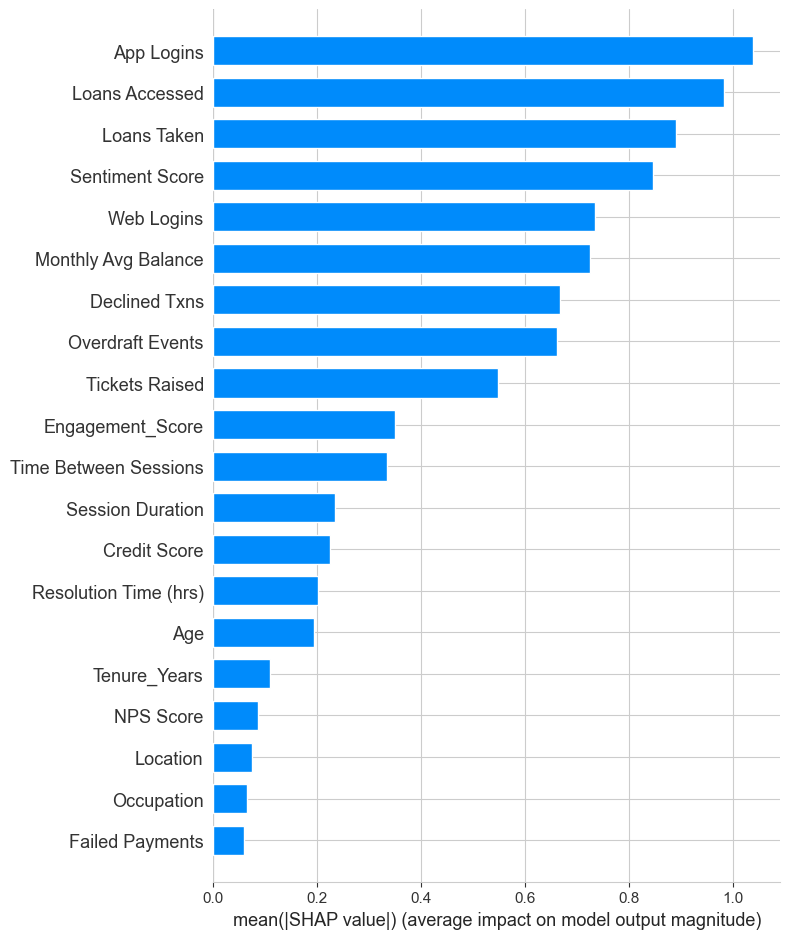

In [39]:
#Step 3: Plot Summary of Churn Drivers
shap.summary_plot(shap_values, X_test, plot_type="bar")


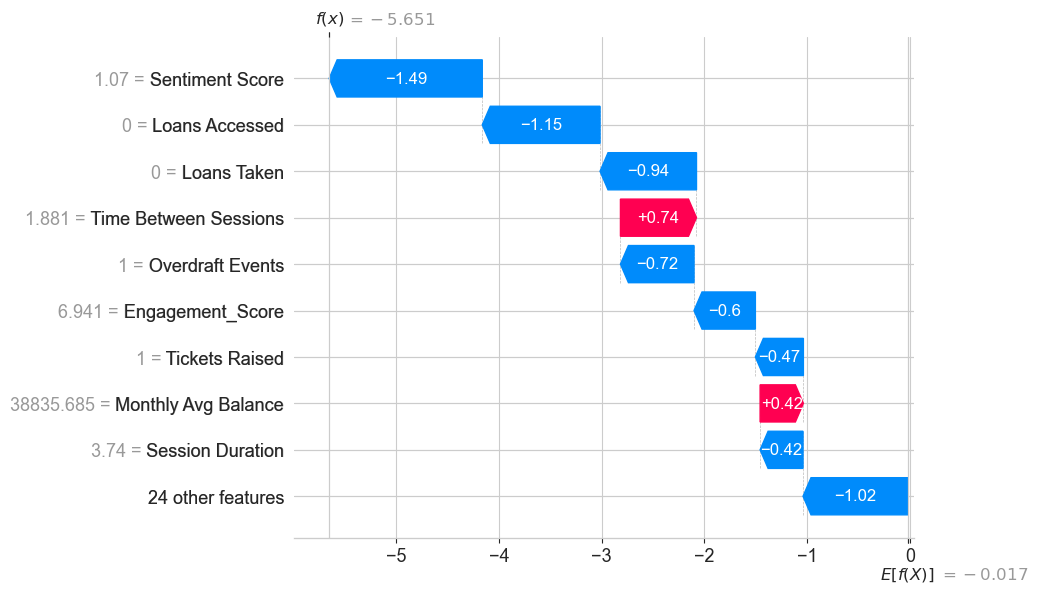

In [40]:
#✅ Step 5: Explain Individual Customers (Force Plot)
# Select an index of a churned customer from test set
i = list(y_test[y_test == 1].index)[0]  # first churned customer
shap.plots.waterfall(shap_values[i], max_display=10)


In [42]:
#✅ Phase 5 Continued: Explain Predictions in Business Terms
#2️⃣ 📊 SHAP DataFrame + CSV Export
#This is the tabular version of that same summary:
shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Impact': shap_values.abs.mean(0).values
})



In [43]:
#✅ Phase 6A: Retention Strategy Design
#🔹 Step 1: Get Churn Probabilities
#Use XGBoost to get churn probability scores:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [44]:
#🔹 Step 2: Segment Customers
#Let’s create 3 churn risk groups:
risk_segment = pd.cut(y_proba_xgb,
                      bins=[0, 0.3, 0.6, 1],
                      labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Add to output DataFrame
results = X_test.copy()
results['Churn_Probability'] = y_proba_xgb
results['Risk_Segment'] = risk_segment


In [45]:
#🔹 Step 3: Map Rule-Based Retention Offers
#You can use simple if-else logic or a lookup:
def recommend_action(risk):
    if risk == 'High Risk':
        return 'Call customer + offer cashback/upgrade'
    elif risk == 'Medium Risk':
        return 'Send personalized offer + follow-up email'
    else:
        return 'Send thank-you email + loyalty points'

results['Recommended_Action'] = results['Risk_Segment'].apply(recommend_action)


In [46]:
#✅ To View the Output:
#Use this code to display a few sample rows from your results DataFrame:
results[['Churn_Probability', 'Risk_Segment', 'Recommended_Action']].head(10)


,Churn_Probability,Risk_Segment,Recommended_Action
5250,0.035229,Low Risk,Send thank-you email + loyalty points
336,0.333024,Medium Risk,Send personalized offer + follow-up email
262,0.006465,Low Risk,Send thank-you email + loyalty points
2208,0.000512,Low Risk,Send thank-you email + loyalty points
8442,0.010167,Low Risk,Send thank-you email + loyalty points
6396,0.205547,Low Risk,Send thank-you email + loyalty points
7584,0.000205,Low Risk,Send thank-you email + loyalty points
7246,0.969413,High Risk,Call customer + offer cashback/upgrade
6823,0.972956,High Risk,Call customer + offer cashback/upgrade
8681,0.035659,Low Risk,Send thank-you email + loyalty points


In [47]:
#🧾 Optional: See Full Table with Features
#If you want to include some of the original customer features too:
results[['App Logins', 'Sentiment Score', 'Churn_Probability', 'Risk_Segment', 'Recommended_Action']].head(10)


,App Logins,Sentiment Score,Churn_Probability,Risk_Segment,Recommended_Action
5250,10.0,0.793708,0.035229,Low Risk,Send thank-you email + loyalty points
336,12.0,0.599941,0.333024,Medium Risk,Send personalized offer + follow-up email
262,14.0,0.750811,0.006465,Low Risk,Send thank-you email + loyalty points
2208,13.0,1.250448,0.000512,Low Risk,Send thank-you email + loyalty points
8442,14.0,0.427671,0.010167,Low Risk,Send thank-you email + loyalty points
6396,14.0,0.625523,0.205547,Low Risk,Send thank-you email + loyalty points
7584,11.0,1.093330,0.000205,Low Risk,Send thank-you email + loyalty points
7246,11.0,0.177516,0.969413,High Risk,Call customer + offer cashback/upgrade
6823,7.0,0.207291,0.972956,High Risk,Call customer + offer cashback/upgrade
8681,15.0,0.177344,0.035659,Low Risk,Send thank-you email + loyalty points


In [48]:
# Step 1: Basic Streamlit Setup
# A. Install Streamlit
!pip install streamlit


In [50]:
results.to_csv("Retention_Recommendation.csv", index=False)


In [52]:
df = pd.read_csv("F:/Quantumsoft Tech/Python/Project/Dummy/Retention_Recommendation.csv")


In [59]:
#Step 1: Define the 6 features
selected_features = [
    'App Logins',
    'Loans Accessed',
    'Loans Taken',
    'Sentiment Score',
    'Web Logins',
    'Monthly Avg Balance'
]



In [60]:
# Step 2: Create X and y
X_selected = df_fe[selected_features]
y = df_fe['Churned']



In [61]:
#Step 3: Train/Test Split (stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)


In [62]:
#Step 4: Train XGBoost Model (on selected features)
from xgboost import XGBClassifier

xgb_selected = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=4,
    random_state=42
)

xgb_selected.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [63]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_selected.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1608
           1       0.58      0.69      0.63       392

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.77      2000
weighted avg       0.85      0.84      0.85      2000

ROC AUC: 0.7837216976342776


In [64]:
import joblib
joblib.dump(xgb_selected, 'xgb_model_selected_features.joblib')


['xgb_model_selected_features.joblib']

In [65]:
import streamlit as st
import numpy as np
import joblib

# 🔄 Load the trained model
model = joblib.load("xgb_model_selected_features.joblib")

st.set_page_config(page_title="Churn Predictor", layout="centered")
st.title("📉 Customer Churn Risk Predictor")
st.write("Enter key behavior metrics to predict churn risk and get retention suggestions.")

# 📋 Input form
app_logins = st.number_input("App Logins", min_value=0)
loans_accessed = st.number_input("Loans Accessed", min_value=0)
loans_taken = st.number_input("Loans Taken", min_value=0)
sentiment_score = st.slider("Sentiment Score", 0.0, 1.0, 0.5)
web_logins = st.number_input("Web Logins", min_value=0)
monthly_balance = st.number_input("Monthly Avg Balance", min_value=0.0)

if st.button("🔍 Predict Churn"):
    # 🧠 Prepare input for prediction
    input_data = np.array([[app_logins, loans_accessed, loans_taken, sentiment_score, web_logins, monthly_balance]])
    churn_prob = model.predict_proba(input_data)[0][1]

    # 📊 Display probability
    st.metric(label="Predicted Churn Probability", value=f"{churn_prob:.2%}")

    # 🧠 Risk Segment Logic
    if churn_prob >= 0.6:
        risk = "High Risk"
        action = "📞 Call customer + Offer cashback or upgrade"
    elif churn_prob >= 0.3:
        risk = "Medium Risk"
        action = "📧 Send personalized email + offer"
    else:
        risk = "Low Risk"
        action = "💌 Send thank-you email + loyalty points"

    # 📢 Display result
    st.success(f"🛡️ Risk Segment: **{risk}**")
    st.info(f"📌 Recommended Action: **{action}**")
